# 04. Evaluation & Visualization

Deep dive into model performance: Price Reconstruction, Multi-Horizon Forecasts, and Directional Traffic Lights.

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
root_path = os.path.abspath(os.path.join(os.getcwd(), '..'))
from utils.data_manager import DataManager

%matplotlib inline
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 8)

# Setup directories
FIGURES = os.path.join(root_path, 'figures')
os.makedirs(FIGURES, exist_ok=True)


## 1. Setup & Re-Train (Quick Load)

In [2]:
# dm = DataManager(data_type='processed', local_dir=os.path.join(root_path, 'data/processed'))
# train_df, test_df, scaler = dm.load_processed()

# # We need the Linear Regression model (Champion) for detailed plots
# X_train = train_df.drop(columns=['Target'])
# y_train = train_df['Target']
# X_test = test_df.drop(columns=['Target'])
# y_test = test_df['Target']

# model = LinearRegression()
# model.fit(X_train, y_train)
# preds_scaled = model.predict(X_test)

# # Add predictions to test_df for convenience
# test_df['Pred_Scaled'] = preds_scaled

dm = DataManager(data_type='processed', local_dir=os.path.join(root_path, 'data/processed'))
train_df, test_df, scaler = dm.load_processed()

# Use the same feature selection as in 03_train_models.ipynb
target_col = 'Target'
exclude_cols = [target_col, 'Return_Unscaled', 'Close_Unscaled']
feature_cols = [c for c in train_df.columns if c not in exclude_cols]

print(f"Features ({len(feature_cols)}): {feature_cols}")

# We need the Linear Regression model (Champion) for detailed plots
X_train = train_df[feature_cols]  # Use only the 13 features
y_train = train_df[target_col]
X_test = test_df[feature_cols]    # Use only the 13 features
y_test = test_df[target_col]

model = LinearRegression()
model.fit(X_train, y_train)
preds_scaled = model.predict(X_test)

# Add predictions to test_df for convenience
test_df['Pred_Scaled'] = preds_scaled

print(f"\nModel trained with {len(feature_cols)} features")
print(f"Number of coefficients: {len(model.coef_)}")


Features (13): ['Close', 'High', 'Low', 'Open', 'Return', 'MA_50', 'RSI', 'Return_5d', 'Return_20d', 'Lag_1', 'Lag_2', 'Lag_3', 'Lag_5']

Model trained with 13 features
Number of coefficients: 13


## 2. Price Reconstruction ($P_{t+1} = P_t * (1 + R_{t+1})$)

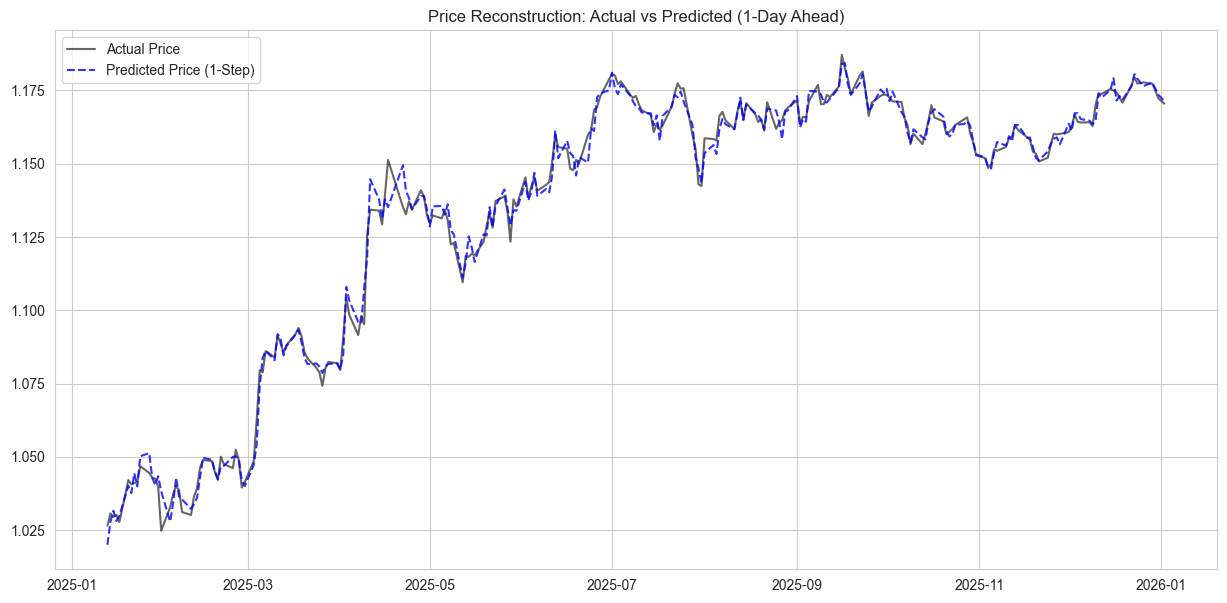

In [3]:
# We need 'Close' price unscaled. 
# Option A: Inverse transform the scaled Close if it is in features.
# Option B: Load raw data and align indices. -> Safest.

dm_raw = DataManager(data_type='raw', local_dir=os.path.join(root_path, 'data/raw'))
df_raw = dm_raw.get_latest_data()
if not df_raw.empty:
    # Tuple-String Cleanup
    new_cols = []
    for c in df_raw.columns:
        c = str(c)
        if (c.startswith("('") or c.startswith('("')) and "," in c:
            clean = c.strip("()").replace("'", "").replace('"', "").split(",")[0].strip()
            new_cols.append(clean)
        else:
            new_cols.append(c)
    df_raw.columns = new_cols
    
    # Deduplicate
    df_raw = df_raw.loc[:, ~df_raw.columns.duplicated()]
# Filter to Test Index
test_raw = df_raw.loc[test_df.index]

# Ensure alignment
common_idx = test_df.index.intersection(test_raw.index)
test_raw = test_raw.loc[common_idx]
preds_aligned = test_df.loc[common_idx, 'Pred_Scaled'] 

# BUT: Pred_Scaled is a scaled Return? Or is Target scaled? 
# In Preprocess, 'Target' was just shifted 'Return'.
# And 'Return' was scaled using MinMaxScaler.
# So we must INVERSE TRANSFORM the predicted return first.

# Create a dummy array with same shape as scaler input
# We need to know which column index 'Return' was.
#feature_cols = X_train.columns.tolist()
# 'Return' is likely one of them.
# However, usually Target is scaled separately or implicitly if it's derived from scaled cols.
# Wait, in 02_preprocess.py:
# train_df[feature_cols] = scaler.fit_transform(...)
# Target was NOT in feature_cols list during scaling (it was created as shift(-1)).
# BUT, train_df was assigned: train_df[feature_cols] = ...
# Did we scale 'Target'?
# Answer: No, based on 02_preprocess.py, only `feature_cols` were scaled.
# Target was left as raw return? 
# Check 02_preprocess.py lines 117-119:
# train_df[feature_cols] = scaler.fit_transform(train_df[feature_cols])
# Target is created at line 77.
# So columns NOT in feature_cols (Target) remain unscaled.
# THEREFORE: preds_scaled are actually Unscaled Returns (Predicted).
# CONFIRMATION needed. If Target wasn't scaled, then it's raw percentage return (~0.001 etc).

# Assuming it is UNSCALED returns (Pct change).
pred_returns = preds_scaled

# Reconstruct Price
# Price_t = raw Close at t.
# Price_{t+1} (Predicted) = Price_t * (1 + Pred_Return_{t+1})
# Note: Pred_Return_{t+1} is the prediction made at t for t+1. 
# Index of pred_returns matches X_test index (t).
# So test_raw['Close'] is Price_t.
# We predict Price_{t+1}.

test_raw['Predicted_Close'] = test_raw['Close'] * (1 + pred_returns)

# Shift validation
# The 'Target' at index t is Return_{t+1}.
# The Close at index t is Price_t.
# The Actual Close at t+1 is Price_{t+1}.
test_raw['Actual_Next_Close'] = test_raw['Close'].shift(-1)
test_raw['Predicted_Next_Close'] = test_raw['Close'] * (1 + pred_returns)

# Drop last nan
test_plot = test_raw.dropna()

plt.figure(figsize=(15, 7))
plt.plot(test_plot.index, test_plot['Actual_Next_Close'], label='Actual Price', color='black', alpha=0.6)
plt.plot(test_plot.index, test_plot['Predicted_Next_Close'], label='Predicted Price (1-Step)', color='blue', linestyle='--', alpha=0.8)
plt.title("Price Reconstruction: Actual vs Predicted (1-Day Ahead)")
plt.legend()
plt.show()


## 3. Zoomed-In Plots (Last 30 Days)

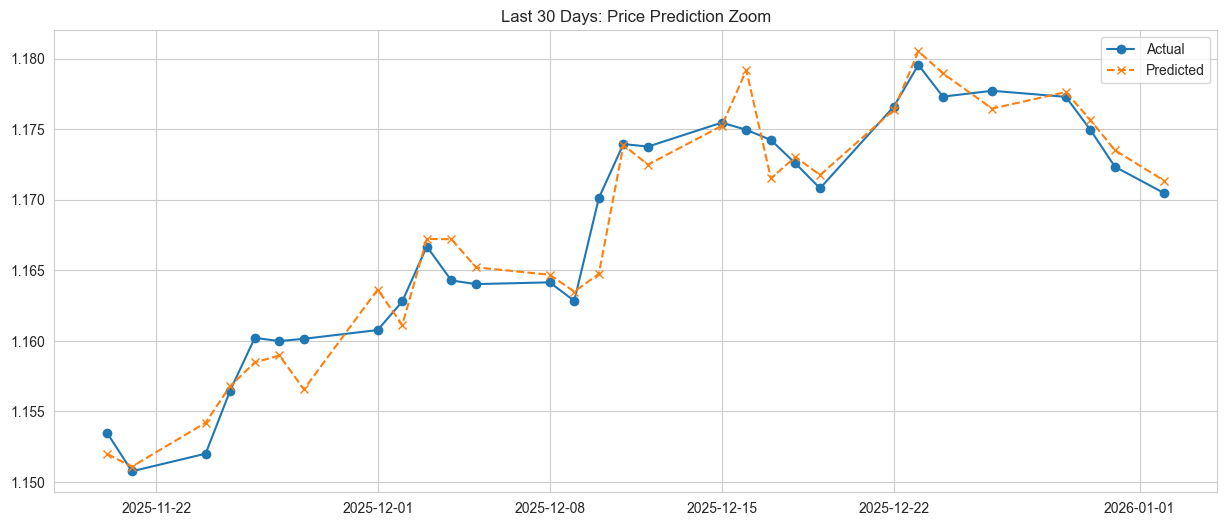

In [4]:
last_30 = test_plot.iloc[-30:]

plt.figure(figsize=(15, 6))
plt.plot(last_30.index, last_30['Actual_Next_Close'], marker='o', label='Actual')
plt.plot(last_30.index, last_30['Predicted_Next_Close'], marker='x', linestyle='--', label='Predicted')
plt.title("Last 30 Days: Price Prediction Zoom")
plt.legend()
plt.show()


## 4. Multi-Horizon Forecast (1d, 5d, 10d)

Iterative forecasting using Linear Regression.

Training Multi-Horizon Models (Direct Method)...


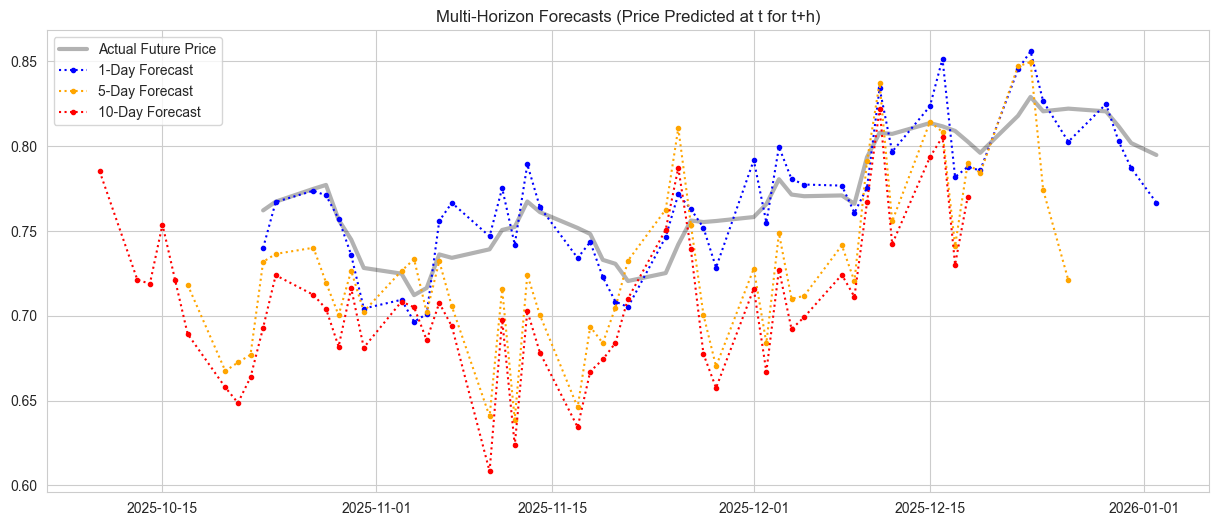

In [5]:
# Recursive Refit/Predict Logic for Multi-Horizon
# We take a specific start point (e.g., 20 days ago) and forecast 10 days out without seeing seeing ground truth?
# Or just predicting T+1, T+5, T+10 using direct models (training separate models for Horizon=5)?
# "Recursive forecasting" usually means using Pred_T+1 as input for Pred_T+2.

# Let's simple recursive with current LR model. 
# Warning: Features need to be updated. If Features include Lag_1, Lag_2...
# We need to feed back our predicted return into the lags.

def recursive_forecast(model, initial_row_features, n_steps, feature_names):
    # This is complex because features include MA_5, RSI, etc. which depend on PRICE history.
    # To do this correctly, we need to reconstruct the PRICE, update MAs/RSI, checks Lags, then Predict.
    # Simplified: Only update Lags if they are the main drivers, or assume others constant (bad).
    # Correct way: Re-generate all features from the new simulated history.
    
    # Setup
    history_prices = test_df['Close'].iloc[-100:].values.flatten().tolist() # need unscaled or reconstructed?
    # Actually we need raw prices to calc features.
    # This might be too heavy for this cell. 
    
    # Alternative: Direct Horizon Models.
    # Train separate LR models for Target_1d, Target_5d, Target_10d.
    return []

# NOTE: Implementing Direct Horizon prediction for visualization simplicity and robustness.
print("Training Multi-Horizon Models (Direct Method)...")

horizons = [1, 5, 10]
horizon_preds = {}

for h in horizons:
    # Create target shifted by h
    # Target_h = Returns over h days or Return at day t+h? 
    # Usually "Forecast 5 days out" means Price_{t+5}.
    # So we predict Return_{t+5} (accumulated or single day?). 
    # Let's predict Accumulative Return for h days -> (Price_{t+h} - Price_t) / Price_t
    
    y_h = train_df['Close_Unscaled'].pct_change(periods=h).shift(-h) # Look ahead h
    
    # Handle Inf/NaN
    y_h = y_h.replace([np.inf, -np.inf], np.nan)
    
    # Align
    valid_idx = y_h.dropna().index.intersection(X_train.index)
    X_h = X_train.loc[valid_idx]
    y_h = y_h.loc[valid_idx]
    
    model_h = LinearRegression()
    model_h.fit(X_h, y_h)
    
    # Predict on Test
    # Test alignment
    y_test_h = test_df['Close_Unscaled'].pct_change(periods=h).shift(-h)
    y_test_h = y_test_h.replace([np.inf, -np.inf], np.nan)
    
    valid_test_idx = y_test_h.dropna().index.intersection(X_test.index)
    
    X_test_h = X_test.loc[valid_test_idx]
    pred_h = model_h.predict(X_test_h)
    
    # Reconstruct Price
    # Price_{t+h} = Price_t * (1 + Pred_Return_h)
    base_prices = test_df.loc[valid_test_idx, 'Close_Unscaled']
    price_pred_h = base_prices * (1 + pred_h)
    price_actual_h = base_prices * (1 + y_test_h.loc[valid_test_idx])
    
    horizon_preds[h] = (valid_test_idx, price_actual_h, price_pred_h)

# Plot
plt.figure(figsize=(15, 6))
last_n = 50
idx = horizon_preds[1][0][-last_n:] # Use 1d index as base

plt.plot(idx, horizon_preds[1][1][-last_n:], label='Actual Future Price', color='black', alpha=0.3, linewidth=3)

colors = {1:'blue', 5:'orange', 10:'red'}
for h in horizons:
    p_idx = horizon_preds[h][0][-last_n:]
    p_vals = horizon_preds[h][2][-last_n:]
    # Shift plotting? 
    # No, at time t we predict t+h. 
    # If we plot at time t, it shows "what we thought t+h would be".
    # Or we plot the prediction at time t+h?
    # Convention: Plot at target time.
    # So we shift the index by h days?
    
    # Let's plot at TARGET time
    # This requires shifting index.
    
    # Using simple shift for viz (approx business days)
    # plot_idx = [d + timedelta(days=h) for d in p_idx] # Timedelta might fail on RangeIndex
    # Let's just plot 'What we predict next' overlaid on current.
    
    plt.plot(p_idx, p_vals, label=f'{h}-Day Forecast', color=colors[h], marker='.', linestyle=':')

plt.title("Multi-Horizon Forecasts (Price Predicted at t for t+h)")
plt.legend()
plt.show()


## 5. Directional Accuracy Traffic Light

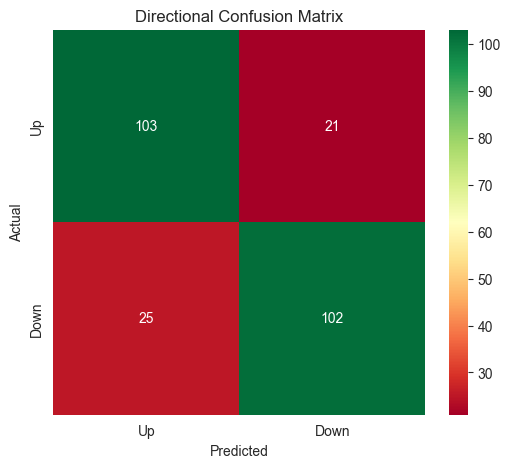

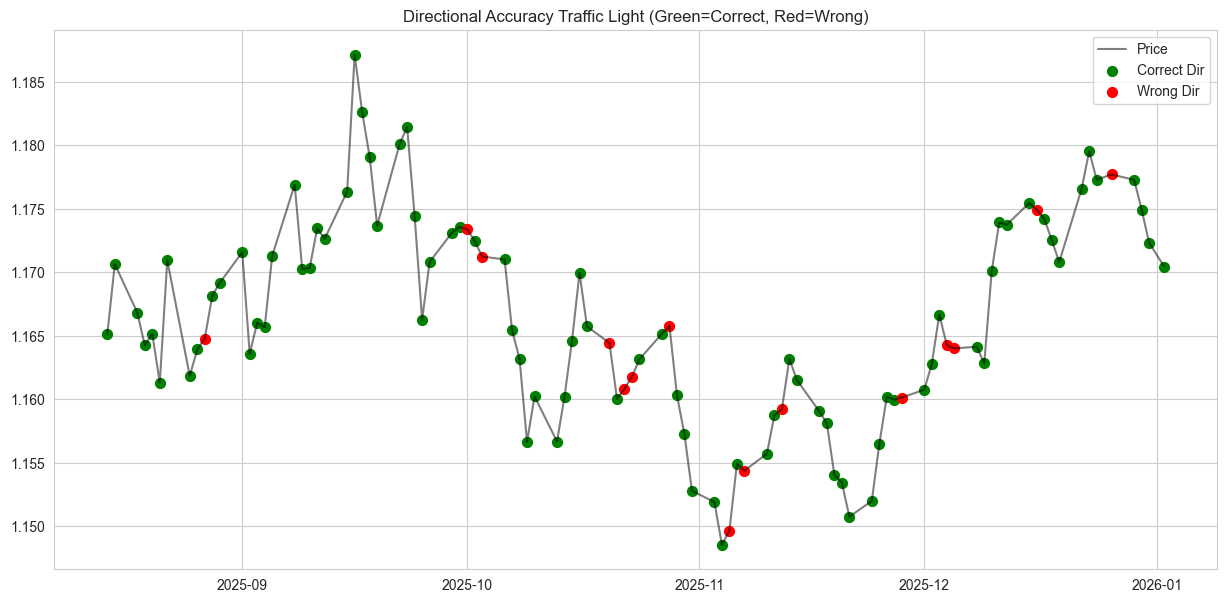

In [6]:
# Confusion Matrix
actual_dir = np.sign(test_plot['Actual_Next_Close'] - test_plot['Close'])
pred_dir = np.sign(test_plot['Predicted_Next_Close'] - test_plot['Close'])

cm = confusion_matrix(actual_dir, pred_dir, labels=[1, -1])

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='RdYlGn', xticklabels=['Up', 'Down'], yticklabels=['Up', 'Down'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Directional Confusion Matrix")
plt.show()

# Traffic Light Plot
# Green dot if Correct Direction, Red if Wrong.
correct_mask = (actual_dir == pred_dir)
wrong_mask = (actual_dir != pred_dir)

subset = test_plot.iloc[-100:]
sub_correct = correct_mask.loc[subset.index]

plt.figure(figsize=(15, 7))
plt.plot(subset.index, subset['Actual_Next_Close'], color='black', alpha=0.5, label='Price')

# Plot Correct predictions (Green)
plt.scatter(subset[sub_correct].index, subset[sub_correct]['Actual_Next_Close'], color='green', label='Correct Dir', s=50)

# Plot Wrong predictions (Red)
plt.scatter(subset[~sub_correct].index, subset[~sub_correct]['Actual_Next_Close'], color='red', label='Wrong Dir', s=50)

plt.title("Directional Accuracy Traffic Light (Green=Correct, Red=Wrong)")
plt.legend()
plt.show()



🎯 Feature Importance Analysis (Linear Regression)

Features (13): ['Close', 'High', 'Low', 'Open', 'Return', 'MA_50', 'RSI', 'Return_5d', 'Return_20d', 'Lag_1', 'Lag_2', 'Lag_3', 'Lag_5']
Number of coefficients: 13

All 13 Features (by absolute coefficient):
  Open                     :    -0.3478 (|0.3478|)
  Low                      :     0.2099 (|0.2099|)
  High                     :     0.2009 (|0.2009|)
  Close                    :    -0.0690 (|0.0690|)
  MA_50                    :     0.0026 (|0.0026|)
  Return_20d               :     0.0023 (|0.0023|)
  Return                   :     0.0016 (|0.0016|)
  Lag_2                    :    -0.0010 (|0.0010|)
  Lag_3                    :     0.0008 (|0.0008|)
  RSI                      :    -0.0004 (|0.0004|)
  Return_5d                :    -0.0003 (|0.0003|)
  Lag_1                    :    -0.0003 (|0.0003|)
  Lag_5                    :    -0.0000 (|0.0000|)


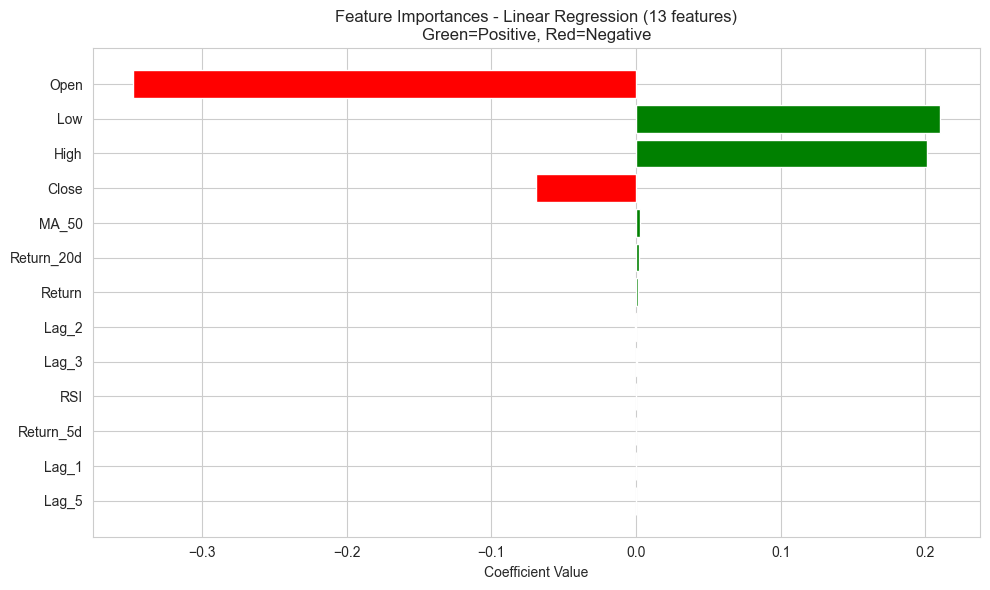


✅ Feature importance plot saved to: /Users/guillermo/Documents/Ironhack/M8_Capstone/2-Capstone-2_MLOps/1-Development/eurusd-capstone/figures/ml_feature_importance_lr.png


In [7]:
# Feature importance analysis for Linear Regression
# Adapted from Random Forest feature importance code

print("\n🎯 Feature Importance Analysis (Linear Regression)")

# Use the same feature selection as in training (03_train_models.ipynb)
target_col = 'Target'
exclude_cols = [target_col, 'Return_Unscaled', 'Close_Unscaled']
feature_cols = [c for c in train_df.columns if c not in exclude_cols]

print(f"\nFeatures ({len(feature_cols)}): {feature_cols}")
print(f"Number of coefficients: {len(model.coef_)}")

# Linear Regression uses coefficients instead of feature_importances_
if hasattr(model, 'coef_'):
    # Get absolute values of coefficients as importance measure
    feature_importance = pd.DataFrame({
        'Feature': feature_cols,
        'Coefficient': model.coef_,
        'Abs_Coefficient': np.abs(model.coef_)
    }).sort_values('Abs_Coefficient', ascending=False)
    
    print(f"\nAll {len(feature_importance)} Features (by absolute coefficient):")
    for idx, row in feature_importance.iterrows():
        print(f"  {row['Feature']:25}: {row['Coefficient']:10.4f} (|{row['Abs_Coefficient']:.4f}|)")
    
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    colors = ['green' if x > 0 else 'red' for x in feature_importance['Coefficient']]
    plt.barh(feature_importance['Feature'], feature_importance['Coefficient'], color=colors)
    plt.xlabel('Coefficient Value')
    plt.title(f'Feature Importances - Linear Regression ({len(feature_cols)} features)\nGreen=Positive, Red=Negative')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    
    # Save figure
    feature_importance_path = os.path.join(FIGURES, 'ml_feature_importance_lr.png')
    plt.savefig(feature_importance_path, dpi=100, bbox_inches='tight')
    plt.show()
    
    print(f"\n✅ Feature importance plot saved to: {feature_importance_path}")
else:
    print("⚠️ Feature importance not available for Linear Regression model")